In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from scipy.optimize import linprog as LP

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets

import PIL

import sys, os
import os.path

import time

import cv2

!pip install opendatasets --upgrade --quiet
import opendatasets as od

EE 769 Course Project :
## Cutting Plane Methods for Optimization in Linear SVM

Gowtham S (20d070031) Anirudh Kansal (20d070013) Gohil Uday (20d070030)

## Dataset 1 (Gaussian clusters)

In [2]:
def generate_gaussian_points(mean, cov, N):
    points = np.random.multivariate_normal(mean, cov, N).astype(np.float32)
    return points

In [3]:
class Dataset1(Dataset):
    def __init__(self, centers, cov, N):
        X1 = generate_gaussian_points(centers[0], cov, N)
        X2 = generate_gaussian_points(centers[1], cov, N)
        Y1 = np.ones(N).astype(np.float32)
        Y2 = -1 * np.ones(N).astype(np.float32)

        self.X = np.concatenate((X1, X2), axis = 0)
        self.Y = np.concatenate((Y1, Y2), axis = 0)
        self.X, self.Y = shuffle(self.X, self.Y, random_state = 0)

        self.dataset = []

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def showdata(self):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for i in range(len(self)):
            color = 'blue' if self.Y[i] == 1 else 'red'
            ax.scatter(self.X[i][0], self.X[i][1], self.X[i][2], color=color, marker='.')
        plt.show()

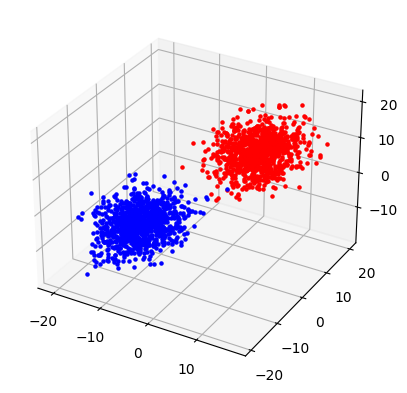

In [4]:
GC = Dataset1([[-10, -8, -6], [6, 8, 10]], [[12, 4, 2], [4, 12, 4], [2, 4, 12]], 1000)
GC.showdata()

## Dataset 2 (Dogs vs Cats)


In [5]:
class Dataset2(Dataset):
    def __init__(self, N):
        dvc_url = 'https://www.kaggle.com/competitions/dogs-vs-cats/data'
        od.download(dvc_url)
        if not os.path.exists('/content/train'):
            sys.stdout = open(os.devnull, 'w')
            !unzip '/content/dogs-vs-cats/train.zip' -d '/content/'
        data_path = '/content/train'
        sys.stdout = sys.__stdout__

        self.X = []
        self.Y = []
        self.data = []
        i = 0
        for filename in os.listdir(data_path):
            if (i < 12500 and i >= N) or (i >= 12500+N):
              continue

            img = cv2.imread(os.path.join(data_path, filename))
            resized_img = cv2.resize(img, (64, 64))
            self.data.append(resized_img)
            data_np = np.ravel(resized_img)
            self.X.append(data_np)

            if 'cat' in filename:
                self.Y.append(-1)
            elif 'dog' in filename:
                self.Y.append(1)

            i += 1

        self.X, self.Y, self.data = shuffle(self.X, self.Y, self.data, random_state = 0)
        self.data = np.array(self.data)
        self.Y = np.array(self.Y)
        self.X = np.array(self.X)

    def __len__(self):
          return len(self.X)

    def __getitem__(self, idx):
          return self.X[idx], self.Y[idx]

    def showdata(self):
        f, ax = plt.subplots(1, 8, figsize=(40, 40))
        datapoints = []
        datalabels = []
        datapoints.append(self.data[self.Y == -1])
        datalabels.append(self.Y[self.Y == -1])
        datapoints.append(self.data[self.Y == 1])
        datalabels.append(self.Y[self.Y == 1])

        for i in range(8):
            ax[i].imshow(PIL.Image.fromarray(np.uint8(datapoints[i%2][i])), cmap = 'gray')
            ax[i].set_title("Label: {}".format(datalabels[i%2][i]), fontsize = 12)

100%|██████████| 812M/812M [00:06<00:00, 131MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


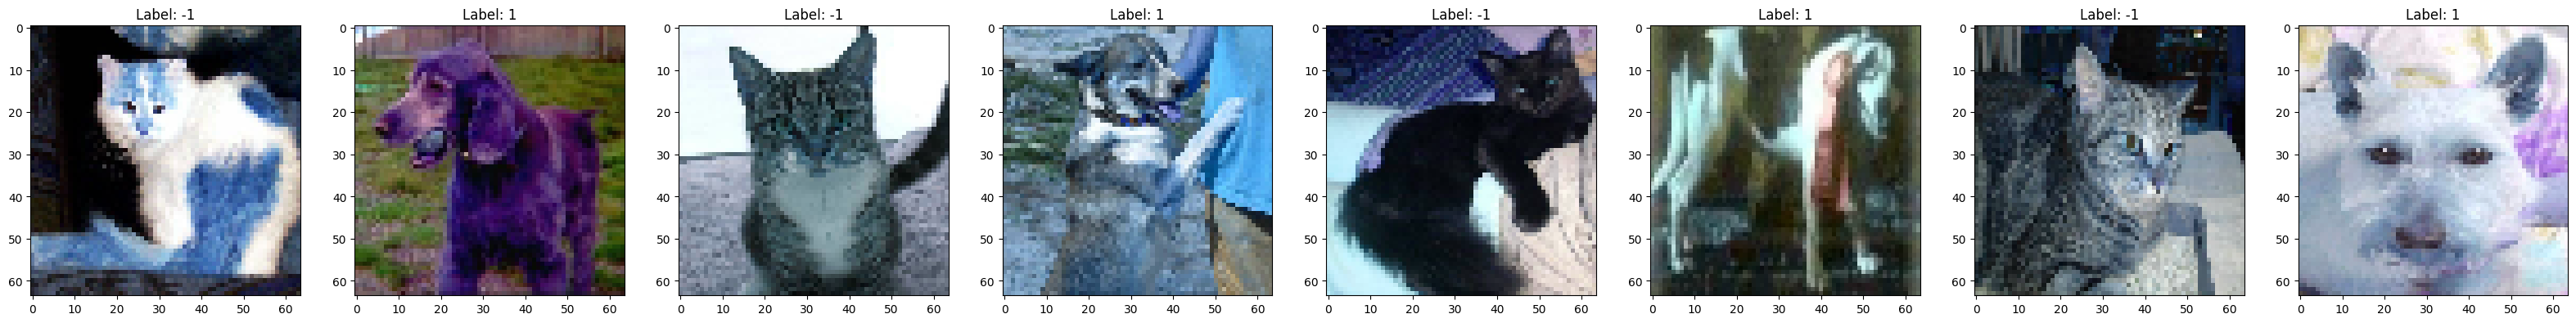

In [6]:
CVD = Dataset2(1000)
CVD.showdata()

## Dataset 3 (MNIST)

In [7]:
class Dataset3(Dataset):
    def __init__(self, N):
        mnist_og = torchvision.datasets.MNIST('/content/', train=True, download=True)
        self.X = []
        self.Y = []
        self.X_og = []
        self.Y_og = []
        for i in range(10000):
            data = np.array(mnist_og[i][0])
            self.X_og.append(data)
            data = data.ravel()
            self.X.append(data)
            label = -1 if mnist_og[i][1] < 5 else 1
            self.Y.append(label)
            self.Y_og.append(mnist_og[i][1])

        self.X = np.array(self.X)
        self.X_og = np.array(self.X_og)
        self.Y = np.array(self.Y)
        self.Y_og = np.array(self.Y_og)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def showdata(self):
        f, ax = plt.subplots(1, 10, figsize=(24, 24))

        for i in range(10):
            datapoint = self.X_og[self.Y_og == i][0]
            datalabel = self.Y[self.Y_og == i][0]
            ax[i].imshow(PIL.Image.fromarray(np.uint8(datapoint)), cmap = 'gray')
            ax[i].set_title("Label: {}".format(datalabel), fontsize = 12)

100%|██████████| 4542/4542 [00:00<00:00, 18459814.70it/s]


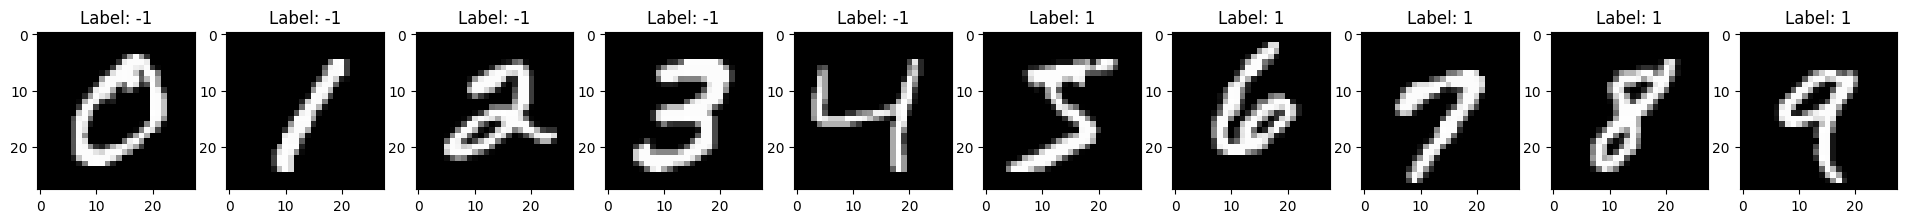

In [8]:
MNIST = Dataset3(10000)
MNIST.showdata()

## Linear Support Vector Classifier

In [9]:
def fitGD(X, y, N, step_size=0.0005, num_epochs=200):
    dim = len(X[0])
    w = torch.autograd.Variable(torch.zeros(dim), requires_grad=True)
    b = 1

    step_size = step_size
    accuracy = []
    duration = []

    for epoch in range(1, num_epochs+1):
        start = time.time()
        L = 0
        for i in range(N):
            L += torch.clamp(1 - y[i] * (torch.dot(w, torch.Tensor(X[i])) - b), min = 0)
        L = L / N
        if L != 0:
            L.backward()
            w.data -= step_size * w.grad.data
            w.grad.data.zero_()
        end = time.time()
        duration.append(end-start)

        correct = 0
        for i in range(N):
            prediction = int(np.sign((torch.dot(w, torch.Tensor(X[i])) - b).detach().numpy()))
            if prediction == y[i]:
                correct += 1

        accuracy.append(correct/N)

    return duration, accuracy

In [10]:
def fitCP(X, y, N, num_epochs=200):
    dim = len(X[0])
    w = np.zeros(dim)
    b = 1
    l = 0

    accuracy = []
    duration = []

    cutting_planes = []
    ubounds = []

    lower_bound = np.hstack((-50*np.ones(dim), 0))
    upper_bound = np.hstack((50*np.ones(dim), np.inf))
    bounds = np.transpose([lower_bound, upper_bound])

    for epoch in range(1, num_epochs+1):
        start = time.time()
        point = w
        hinge_loss = np.clip(1 - y*(np.dot(X, w) - b), 0, np.inf)
        value = np.sum(hinge_loss) / N
        hinge_loss[hinge_loss>0] = 1
        gradient = -np.dot(X.T, y*hinge_loss) / N
        ubounds.append(np.dot(gradient, point) - value)
        cutting_planes.append(np.hstack((gradient, -1)))

        c = np.zeros(dim+1)
        c[-1] = 1
        minimum = LP(c, A_ub=cutting_planes, b_ub=ubounds, bounds=bounds).x
        w = minimum[:-1]
        l = minimum[-1]
        end = time.time()
        duration.append(end-start)


        correct = 0
        prediction = np.sign(np.dot(X, w) - b)
        for i in range(N):
            if prediction[i] == y[i]:
                correct += 1

        accuracy.append(correct/N)

    return duration, accuracy

In [11]:
tg1, ag1 = fitGD(GC.X, GC.Y, len(GC))
tc1, ac1 = fitCP(GC.X, GC.Y, len(GC))

In [12]:
tg2, ag2 = fitGD(CVD.X, CVD.Y, len(CVD))
tc2, ac2 = fitCP(CVD.X, CVD.Y, len(CVD))

In [13]:
tg3, ag3 = fitGD(MNIST.X, MNIST.Y, len(MNIST))
tc3, ac3 = fitCP(MNIST.X, MNIST.Y, len(MNIST))

## SVC with Regularization

In [14]:
def fitGDRegularized(X, y, N, regularizer=0.2, step_size=0.0005, num_epochs=200):
    dim = len(X[0])
    w = torch.autograd.Variable(torch.zeros(dim), requires_grad=True)
    b = 1

    step_size = step_size
    accuracy = []
    duration = []

    for epoch in range(1, num_epochs+1):
        start = time.time()
        L = 0
        for i in range(N):
            L += torch.clamp(1 - y[i] * (torch.dot(w, torch.Tensor(X[i])) - b), min = 0) + regularizer*torch.dot(w, w)
        L = L / N
        if L != 0:
            L.backward()
            w.data -= step_size * w.grad.data
            w.grad.data.zero_()
        end = time.time()
        duration.append(end-start)

        correct = 0
        for i in range(N):
            prediction = int(np.sign((torch.dot(w, torch.Tensor(X[i])) - b).detach().numpy()))
            if prediction == y[i]:
                correct += 1

        accuracy.append(correct/N)

    return duration, accuracy

In [15]:
def fitCPRegularized(X, y, N, regularizer=0.2, num_epochs=200):
    dim = len(X[0])
    w = np.zeros(dim)
    b = 1

    accuracy = []
    duration = []

    cutting_planes = []
    ubounds = []
    lower_bound = np.hstack((-50*np.ones(dim), 0))
    upper_bound = np.hstack((50*np.ones(dim), np.inf))
    bounds = np.transpose([lower_bound, upper_bound])

    for epoch in range(num_epochs):
        start = time.time()
        point = w
        hinge_loss = np.clip(1 - y*(np.dot(X, w) - b), 0, np.inf)
        value = regularizer*np.dot(w, w) + np.sum(hinge_loss) / N
        hinge_loss[hinge_loss>0] = 1
        gradient = -np.dot(X.T, y*hinge_loss) / N
        gradient = gradient + 2*regularizer*w
        ubounds.append(np.dot(gradient, point) - value)
        cutting_planes.append(np.hstack((gradient, -1)))

        c = np.zeros(dim+1)
        c[-1] = 1
        minimum = LP(c, A_ub=cutting_planes, b_ub=ubounds, bounds=bounds).x
        w = minimum[:-1]
        end = time.time()
        duration.append(end-start)

        correct = 0
        prediction = np.sign(np.dot(X, w) - b)
        for i in range(N):
            if prediction[i] == y[i]:
                correct += 1

        accuracy.append(correct/N)

    return duration, accuracy

# SVC using Bundle Method

In [16]:
def fitCPBundle(X, y, N, regularizer=0.2, num_epochs=200):
    dim = len(X[0])
    w = np.zeros(dim)
    b = 1

    accuracy = []
    duration = []

    cutting_planes = []
    ubounds = []
    lower_bound = np.hstack((-50*np.ones(dim), 0))
    upper_bound = np.hstack((50*np.ones(dim), np.inf))
    bounds = np.transpose([lower_bound, upper_bound])

    for epoch in range(num_epochs):
        start = time.time()
        point = w
        hinge_loss = np.clip(1 - y*(np.dot(X, w) - b), 0, np.inf)
        value = regularizer*np.dot(w, w) + np.sum(hinge_loss) / N
        hinge_loss[hinge_loss>0] = 1
        gradient = -np.dot(X.T, y*hinge_loss) / N
        gradient = gradient # + 2*regularizer*w
        ubounds.append(np.dot(gradient, point) - value)
        cutting_planes.append(np.hstack((gradient, -1)))

        c = np.zeros(dim+1)
        c[-1] = 1
        minimum = LP(c, A_ub=cutting_planes, b_ub=ubounds, bounds=bounds).x
        w = minimum[:-1]
        end = time.time()
        duration.append(end-start)

        correct = 0
        prediction = np.sign(np.dot(X, w) - b)
        for i in range(N):
            if prediction[i] == y[i]:
                correct += 1

        accuracy.append(correct/N)

    return duration, accuracy

In [17]:
trg1, arg1 = fitGDRegularized(GC.X, GC.Y, len(GC))
trc1, arc1 = fitCPRegularized(GC.X, GC.Y, len(GC))
trc1_n, arc1_n = fitCPBundle(GC.X, GC.Y, len(GC))

In [18]:
trg2, arg2 = fitGDRegularized(CVD.X, CVD.Y, len(CVD))
trc2, arc2 = fitCPRegularized(CVD.X, CVD.Y, len(CVD))
trc2_n, arc2_n = fitCPBundle(CVD.X, CVD.Y, len(CVD))

In [19]:
trg3, arg3 = fitGDRegularized(MNIST.X, MNIST.Y, len(MNIST))
trc3, arc3 = fitCPRegularized(MNIST.X, MNIST.Y, len(MNIST))
trc3_n, arc3_n = fitCPBundle(MNIST.X, MNIST.Y, len(MNIST))

## Comparison of performance

In [ ]:
epochs = range(0, 200)
plt.plot(epochs, ag1, 'g', label='Gradient Descent')
plt.plot(epochs, ac1, 'b', label='Cutting Plane')
plt.title('Accuracy for gaussian clusters dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

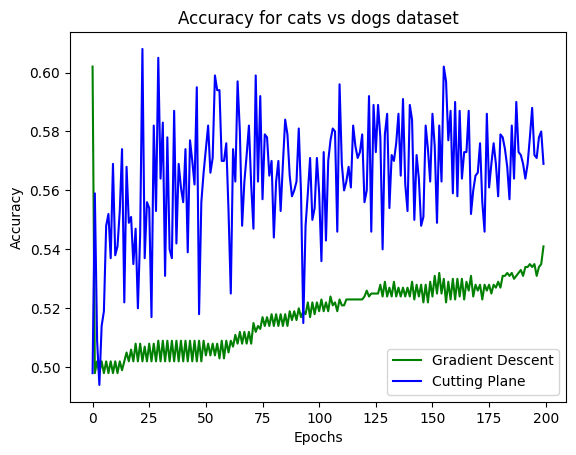

In [21]:
epochs = range(0, 200)
plt.plot(epochs, ag2, 'g', label='Gradient Descent')
plt.plot(epochs, ac2, 'b', label='Cutting Plane')
plt.title('Accuracy for cats vs dogs dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

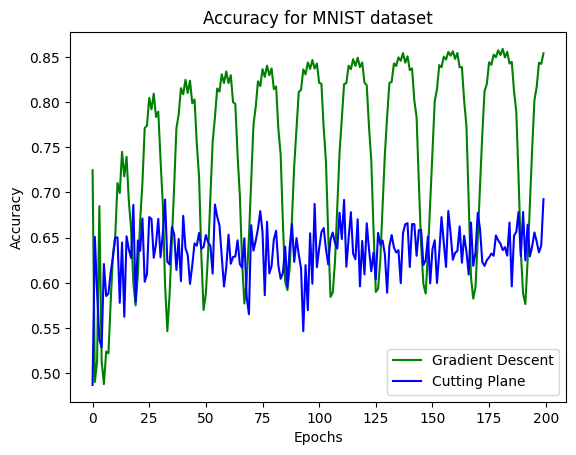

In [22]:
epochs = range(0, 200)
plt.plot(epochs, ag3, 'g', label='Gradient Descent')
plt.plot(epochs, ac3, 'b', label='Cutting Plane')
plt.title('Accuracy for MNIST dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
gct1 = sum(tg1)
gct2 = sum(tc1)
cvdt1 = sum(tg2)
cvdt2 = sum(tc2)
mnistt1 = sum(tg3)
mnistt2 = sum(tc3)

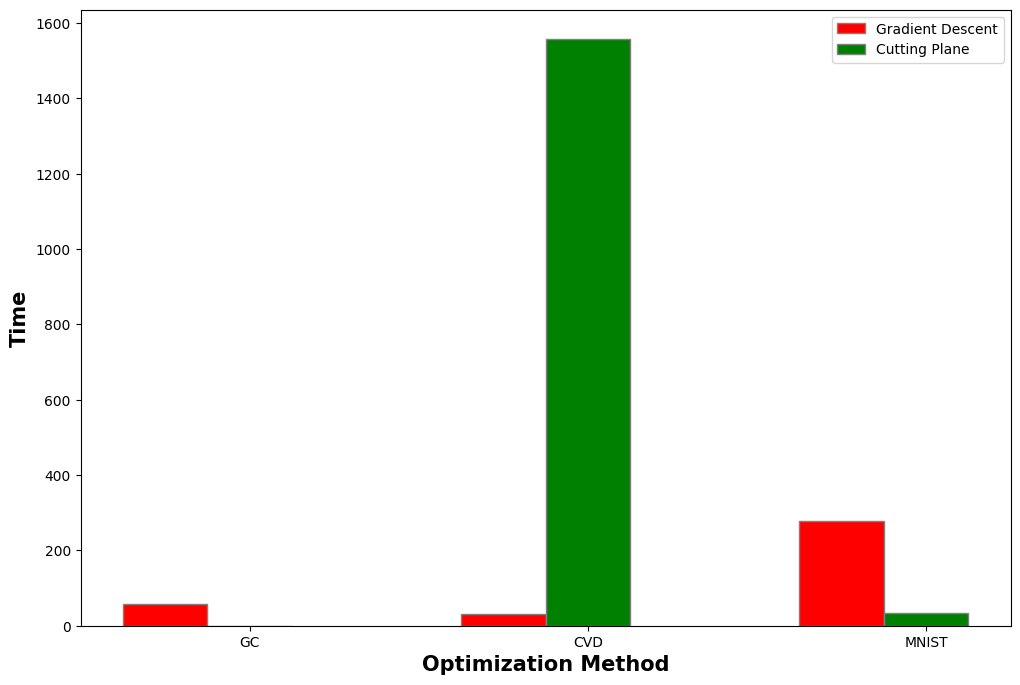

In [24]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

GC = [gct1, cvdt1, mnistt1]
CP = [gct2, cvdt2, mnistt2]

br1 = np.arange(len(GC))
br2 = [x + barWidth for x in br1]

plt.bar(br1, GC, color ='r', width = barWidth,
        edgecolor ='grey', label ='Gradient Descent')
plt.bar(br2, CP, color ='g', width = barWidth,
        edgecolor ='grey', label ='Cutting Plane')

plt.xlabel('Optimization Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Time', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(GC))],
        ['GC', 'CVD', 'MNIST'])
 
plt.legend()
plt.show()

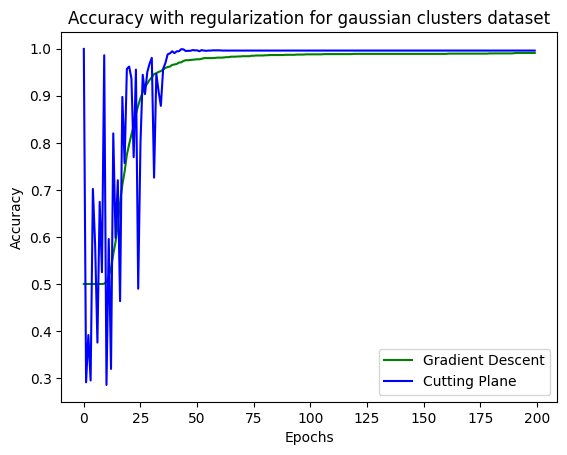

In [25]:
epochs = range(0, 200)
plt.plot(epochs, arg1, 'g', label='Gradient Descent')
plt.plot(epochs, arc1, 'b', label='Cutting Plane')
plt.title('Accuracy with regularization for gaussian clusters dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

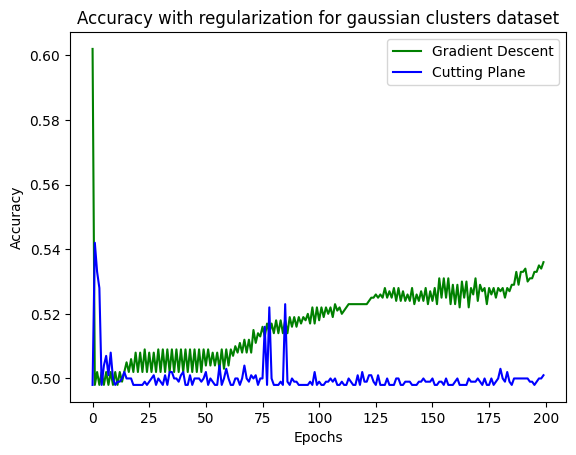

In [26]:
epochs = range(0, 200)
plt.plot(epochs, arg2, 'g', label='Gradient Descent')
plt.plot(epochs, arc2, 'b', label='Cutting Plane')
plt.title('Accuracy with regularization for gaussian clusters dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

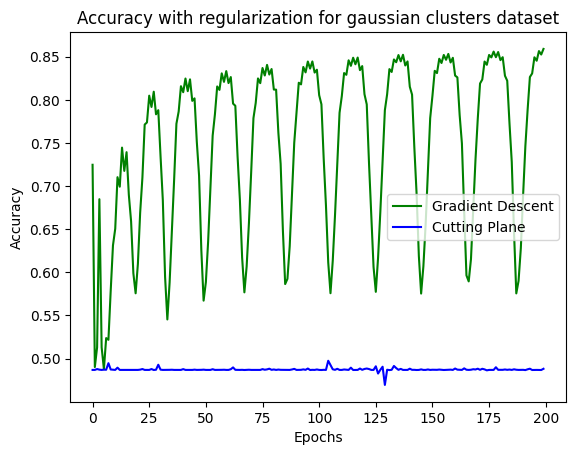

In [27]:
epochs = range(0, 200)
plt.plot(epochs, arg3, 'g', label='Gradient Descent')
plt.plot(epochs, arc3, 'b', label='Cutting Plane')
plt.title('Accuracy with regularization for gaussian clusters dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
gct1 = sum(trg1)
gct2 = sum(trc1)
cvdt1 = sum(trg2)
cvdt2 = sum(trc2)
mnistt1 = sum(trg3)
mnistt2 = sum(trc3)

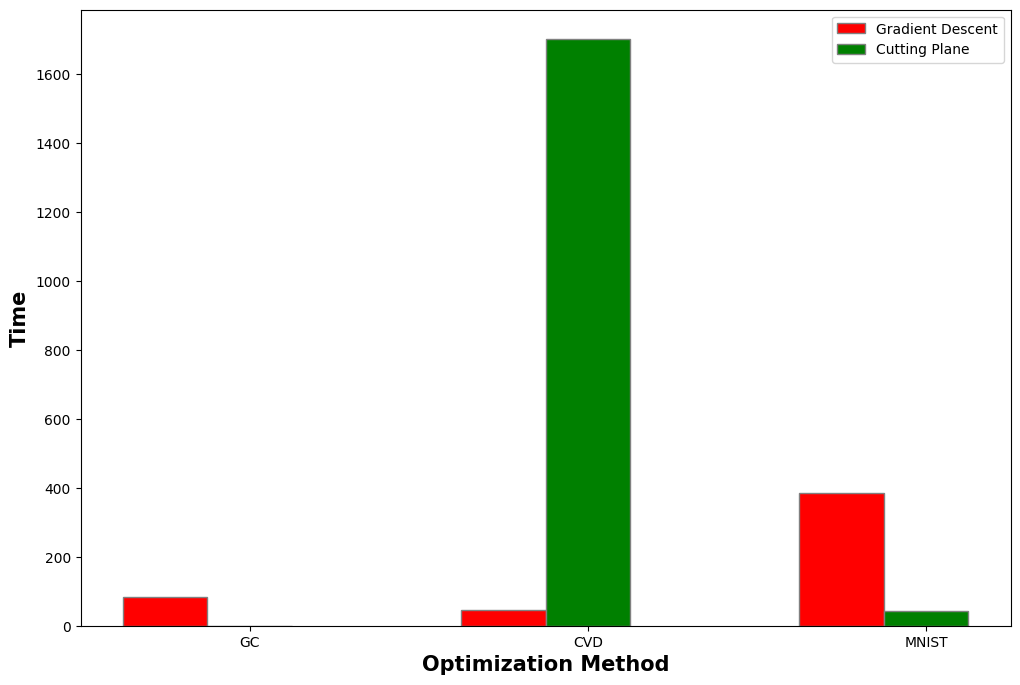

In [29]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

GC = [gct1, cvdt1, mnistt1]
CP = [gct2, cvdt2, mnistt2]

br1 = np.arange(len(GC))
br2 = [x + barWidth for x in br1]

plt.bar(br1, GC, color ='r', width = barWidth,
        edgecolor ='grey', label ='Gradient Descent')
plt.bar(br2, CP, color ='g', width = barWidth,
        edgecolor ='grey', label ='Cutting Plane')

plt.xlabel('Optimization Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Time', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(GC))],
        ['GC', 'CVD', 'MNIST'])
 
plt.legend()
plt.show()

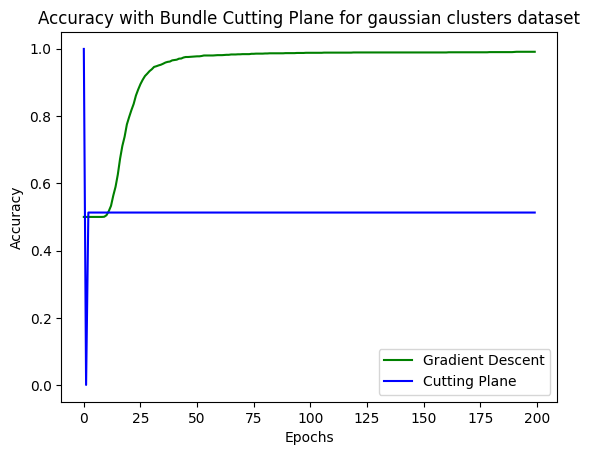

In [30]:
epochs = range(0, 200)
plt.plot(epochs, arg1, 'g', label='Gradient Descent')
plt.plot(epochs, arc1_n, 'b', label='Cutting Plane')
plt.title('Accuracy with Bundle Cutting Plane for gaussian clusters dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

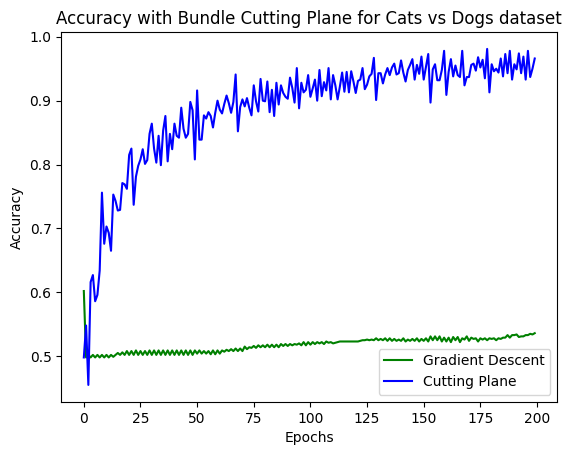

In [31]:
epochs = range(0, 200)
plt.plot(epochs, arg2, 'g', label='Gradient Descent')
plt.plot(epochs, arc2_n, 'b', label='Cutting Plane')
plt.title('Accuracy with Bundle Cutting Plane for Cats vs Dogs dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

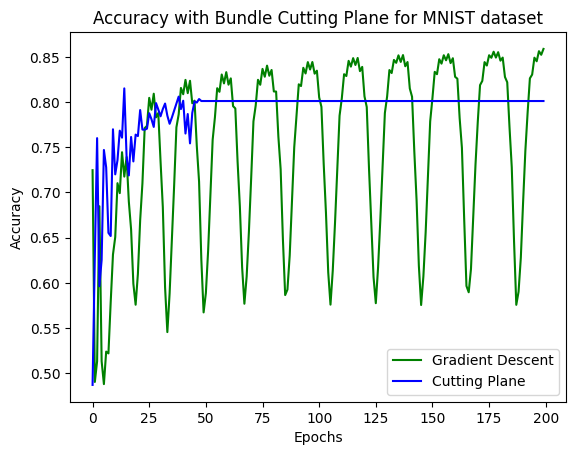

In [32]:
epochs = range(0, 200)
plt.plot(epochs, arg3, 'g', label='Gradient Descent')
plt.plot(epochs, arc3_n, 'b', label='Cutting Plane')
plt.title('Accuracy with Bundle Cutting Plane for MNIST dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
gct1 = sum(trg1)
gct2 = sum(trc1_n)
cvdt1 = sum(trg2)
cvdt2 = sum(trc2_n)
mnistt1 = sum(trg3)
mnistt2 = sum(trc3_n)

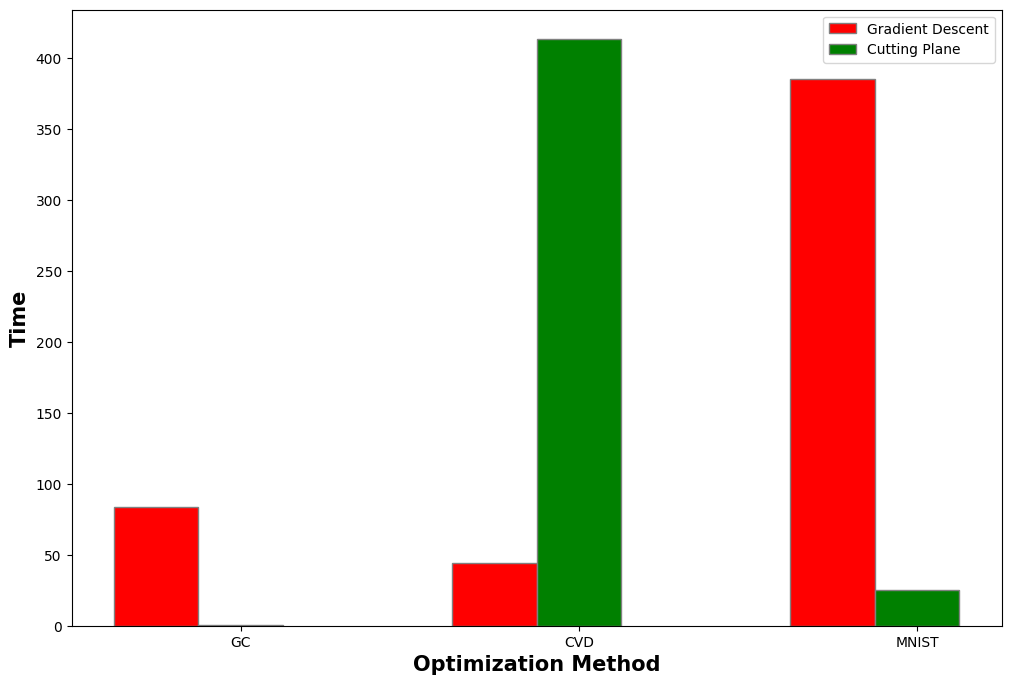

In [34]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

GC = [gct1, cvdt1, mnistt1]
CP = [gct2, cvdt2, mnistt2]

br1 = np.arange(len(GC))
br2 = [x + barWidth for x in br1]

plt.bar(br1, GC, color ='r', width = barWidth,
        edgecolor ='grey', label ='Gradient Descent')
plt.bar(br2, CP, color ='g', width = barWidth,
        edgecolor ='grey', label ='Cutting Plane')

plt.xlabel('Optimization Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Time', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(GC))],
        ['GC', 'CVD', 'MNIST'])
 
plt.legend()
plt.show()